In [145]:

!python run.py

Figure(480x480)
 14%|████▉                               | 13638/100000 [02:21<14:38, 98.28it/s]
DONE:  Pursuer wins
 28%|██████████▏                         | 28431/100000 [04:55<14:42, 81.13it/s]
DONE:  Pursuer wins
 29%|██████████                         | 28670/100000 [04:57<11:19, 105.03it/s]
DONE:  Pursuer wins
100%|███████████████████████████████████| 100000/100000 [28:49<00:00, 57.83it/s]
159
2021-05-27 16:40:13.344 python[9410:1009734] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcbd2f17330>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-05-27 16:40:13.345 python[9410:1009734] Warning: Expected min height of view: (<NSButton: 0x7fcbd3020780>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-05-27 16:40:13.349 python[9410:1009734] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcbd

In [93]:
import gym
import numpy as np
# from epgame_v2 import EPGame,save_results

import gym
from gym import spaces
import numpy as np
from gym.utils import seeding
from gym.envs.classic_control import rendering
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def compute_rgb_array(env,evader_policy,pursuer_policy,max_iters):
    rgb_array = []
    done = False
    obs = env.reset()
    i = 0
    while (not done) and i < max_iters:
        evader_action_index = evader_policy[obs] # in [0,1,2,3]
        obs, reward, done, info = env.evader_step(evader_action_index)
        pursuer_action_index = pursuer_policy[obs] # in [0,1,2,3]
        obs, reward, done, info = env.pursuer_step(pursuer_action_index)
        rgb_array.append(env.render("rgb_array"))
        i+=1
    return rgb_array

def save_results(env,evader_policy,pursuer_policy,max_iters = 100,name = "policy_example"):
    
    """
    Usage:
    evader_policy: array of size [x_max,y_max,x_max,y_max] with int values form 0 to 3 (inclusive);
    pursuer_policy: array of size [x_max,y_max,x_max,y_max] with int values form 0 to 3 (inclusive).
    
    """

    im_array = compute_rgb_array(env,evader_policy,pursuer_policy,max_iters)
    fig = plt.figure(figsize=(30,30))
    imgs = []
    for im in im_array:
        plot = plt.imshow(im)
        imgs.append([plot])

    ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True)

    ani.save(name +'.mp4')

    plt.show()



def default_reward(x_e,x_p,goal):
    x_e = np.array(x_e)
    x_p = np.array(x_p)
    goal = np.array(goal)
    if tuple(goal) != (None,None):
        r = -np.linalg.norm(x_e-goal) + np.linalg.norm(x_e-x_p) 
    else:
        r = np.linalg.norm(x_e-x_p) 
    if tuple(x_e) == tuple(goal):
        r += 100
    return r
    
    
class EPGame(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }
    
    
    def __init__(self,env_map,reward = None, use_goal=False, seed_num = 781):
        self.done = False
        self.use_goal = use_goal
        
        self.seed_num = seed_num
        self.reward = reward  if reward != None else default_reward
        
        self.env_map = np.array(env_map)
        self._total_actions = [(-1,0),(0,-1),(1,0),(0,1)]
        
        self.visited_states = np.full(np.r_[env_map.shape,env_map.shape,2],False)

        x_max,y_max = self.env_map.shape
        
        self.evader_action_space = spaces.MultiDiscrete(len(self._total_actions))
        self.evader_observation_space = spaces.MultiDiscrete([x_max,y_max,x_max,y_max])
        
        self.pursuer_action_space = spaces.MultiDiscrete(len(self._total_actions))
        self.pursuer_observation_space = spaces.MultiDiscrete([x_max,y_max,x_max,y_max])
        
        self.seed()
        
        self.viewer = None
        self.reset()
        
    def update_allowed_actions(self,evador_actions):
        self.allowed_actions = []
        if evador_actions:
            for a_index,a in enumerate(self._total_actions):
                x_e = tuple(self.transition(self.x_e,a))
                x_p = tuple(self.x_p)
                joint_state = x_e+x_p+(1,) #1 = pursuer state
                if self.visited_states[joint_state] == False:
                    self.allowed_actions.append(a_index)
        else:
            for a_index,a in enumerate(self._total_actions):
                x_p = tuple(self.transition(self.x_p,a))
                x_e = tuple(self.x_e)
                joint_state = x_e+x_p+(0,) #1 = evador state
                if self.visited_states[joint_state] == False:
                    self.allowed_actions.append(a_index)
                    
                
    def evader_step(self,action_index):
        assert action_index in self.allowed_actions, "Action is not allowed"
        assert self.evaders_turn == True, "It is the pursuer turn to make step"
        action = self._total_actions[action_index]
        self.x_e = self.transition(self.x_e,action)
        self.state = tuple(np.r_[self.x_e,self.x_p])
        self.visited_states[ self.state+(1,)] = True #1 = pursuer state
        reward = self.compute_reward()
        done = (tuple(self.x_e) == tuple(self.x_p)) or (tuple(self.x_e) == tuple(self.goal))
        self.evaders_turn = False
        self.pursuers_turn = True
        self.update_allowed_actions(evador_actions = False)
        return self.state, reward, done,{}
    

            
            
    
    def pursuer_step(self,action_index):

        assert action_index in self.allowed_actions, "Action is not allowed"
        
        assert self.pursuers_turn == True, "It is the evader turn to make step"
        action = self._total_actions[action_index]
        self.x_p = self.transition(self.x_p,action)
        self.state = tuple(np.r_[self.x_e,self.x_p])
        self.visited_states[ self.state+(0,)] = True #0 = evader state
        reward = self.compute_reward()
        done = (tuple(self.x_e) == tuple(self.x_p)) or (tuple(self.x_e) == tuple(self.goal))
        self.evaders_turn = True
        self.pursuers_turn = False
        self.update_allowed_actions(evador_actions = True)
        return self.state, reward, done,{}

    def transition(self,x,u):
        """Transition function for states in this problem
        x: current state, this is a tuple (i,j)
        u: current action, this is a tuple (i,j)
        env: enviroment

        Output:
        new state
        True if correctly propagated
        False if this action can't be executed
        """
        xnew = np.array(x) + np.array(u)
        #print('xnew',xnew)
        if self.state_is_consistent(xnew):
            return xnew
        return x

    def state_is_consistent(self,x):
        x = tuple(x)
        """Checks wether or not the proposed state is a valid state, i.e. is in colision or our of bounds"""
        # check for collision
        if x[0] < 0 or x[1] < 0 or x[0] >= self.env_map.shape[0] or x[1] >= self.env_map.shape[1] :
            #print('out of bonds')
            return False
        if self.env_map[x] >= 1.0-1e-4:
            #print('Obstacle')
            return False
        if tuple(self.x_e) == tuple(self.x_p):
            #print('Сaught')
            return False
        if tuple(self.x_e) == tuple(self.goal):
            #print('Goal')
            return False
        return True
        
        
    def compute_reward(self):
        return self.reward(self.x_e,self.x_p,self.goal)

        
        
    def reset(self):
        self.seed(self.seed_num)
        
        self.evaders_turn = True
        self.pursuers_turn = False
        
        x1_max,x2_max = self.env_map.shape
        free_space = np.argwhere(self.env_map == 0)
        x_e_index,x_p_index,goal_index = self.np_random.choice(np.arange(0,len(free_space)),3,replace = False)
        self.x_e, self.x_p, self.goal = free_space[x_e_index],free_space[x_p_index],free_space[goal_index]
        if not self.use_goal:
            self.goal = (None, None)
        
        self.state = tuple(np.r_[self.x_e,self.x_p])
        self.visited_states[ self.state+(0,)] = True #0 = evader state
        self.update_allowed_actions(evador_actions = True)
        return self.state
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    

    def render(self, mode='human'):
        map_with_bounds = np.empty((self.env_map.shape[0]+2,self.env_map.shape[1]+2))
        map_with_bounds[0,:] = map_with_bounds[-1,:] = map_with_bounds[:,0] = map_with_bounds[:,-1] = 1
        map_with_bounds[1:-1,1:-1] = self.env_map
        
        scale = 20
        screen_width,screen_height = (np.array(map_with_bounds.shape)-1) * scale
        dx=dy= 1/2*scale
        agent_size = scale
        


        if self.viewer is None:
            
            self.viewer = rendering.Viewer(screen_width, screen_height)
            walls = np.argwhere(map_with_bounds >0)*scale
            
            evader = rendering.make_circle(agent_size/2)
            evader.set_color(0, 0, 255)
            self.evadertrans = rendering.Transform()
            evader.add_attr(self.evadertrans)
            self.viewer.add_geom(evader)
            
            pursuer = rendering.make_circle(agent_size/2)
            pursuer.set_color(255, 0, 0)
            self.pursuertrans = rendering.Transform()
            pursuer.add_attr(self.pursuertrans)
            self.viewer.add_geom(pursuer)
            
            goal = rendering.make_circle(agent_size/2)
            goal.set_color(0, 255, 0)
            self.goaltrans = rendering.Transform()
            goal.add_attr(self.goaltrans)
            self.viewer.add_geom(goal)

            for x,y in walls:
                brick= rendering.FilledPolygon([(x-dx, y-dy),(x-dx, y+dy),(x+dx, y+dy), (x+dx,y-dy)])
                self.viewer.add_geom(brick)

        x_e = (self.x_e+1)*scale
        x_p = (self.x_p+1)*scale
        if self.use_goal:
            goal = (self.goal+1)*scale
            self.goaltrans.set_translation(*goal)
        
        self.evadertrans.set_translation(*x_e)
        self.pursuertrans.set_translation(*x_p)
        

        

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')


In [101]:
data = np.load('data_ps3.npz')
env_map = data['environment']

env = EPGame(env_map,seed_num = 200,use_goal = True)


In [102]:
state, reward, done,_ = env.evader_step(3)
x_p, x_e = state[:2],state[2:]
env.render()
print(state, reward, done)

state, reward, done,_ = env.pursuer_step(3)
env.render()
print(state, reward, done)

(24, 3, 26, 29) 4.122311220710447 False
(24, 3, 26, 29) 4.122311220710447 False


In [64]:
env.allowed_actions

[0, 1, 2, 3]

In [12]:
class Tree

class UCTS:
    def __init__(self, env):
        self.env = env
        self.Qe = np.zeros(env.evader_observation_space.nvec)
        self.Qp = np.zeros(env.pursuer_observation_space.nvec)
    

def UCTSearch(num_iters):
    for i in range(num_iters):
        simulate

(22, 29, 2, 25) -0.1476213230545511 False


In [26]:
30**4*8/1e6

6.48

In [19]:
np.zeros(np.r_[env.evader_observation_space.nvec,env.pursuer_observation_space.nvec])

KeyboardInterrupt: 

In [23]:
np.r_[env.evader_observation_space.nvec,env.pursuer_observation_space.nvec]
30**8*8/1e9

5248.8

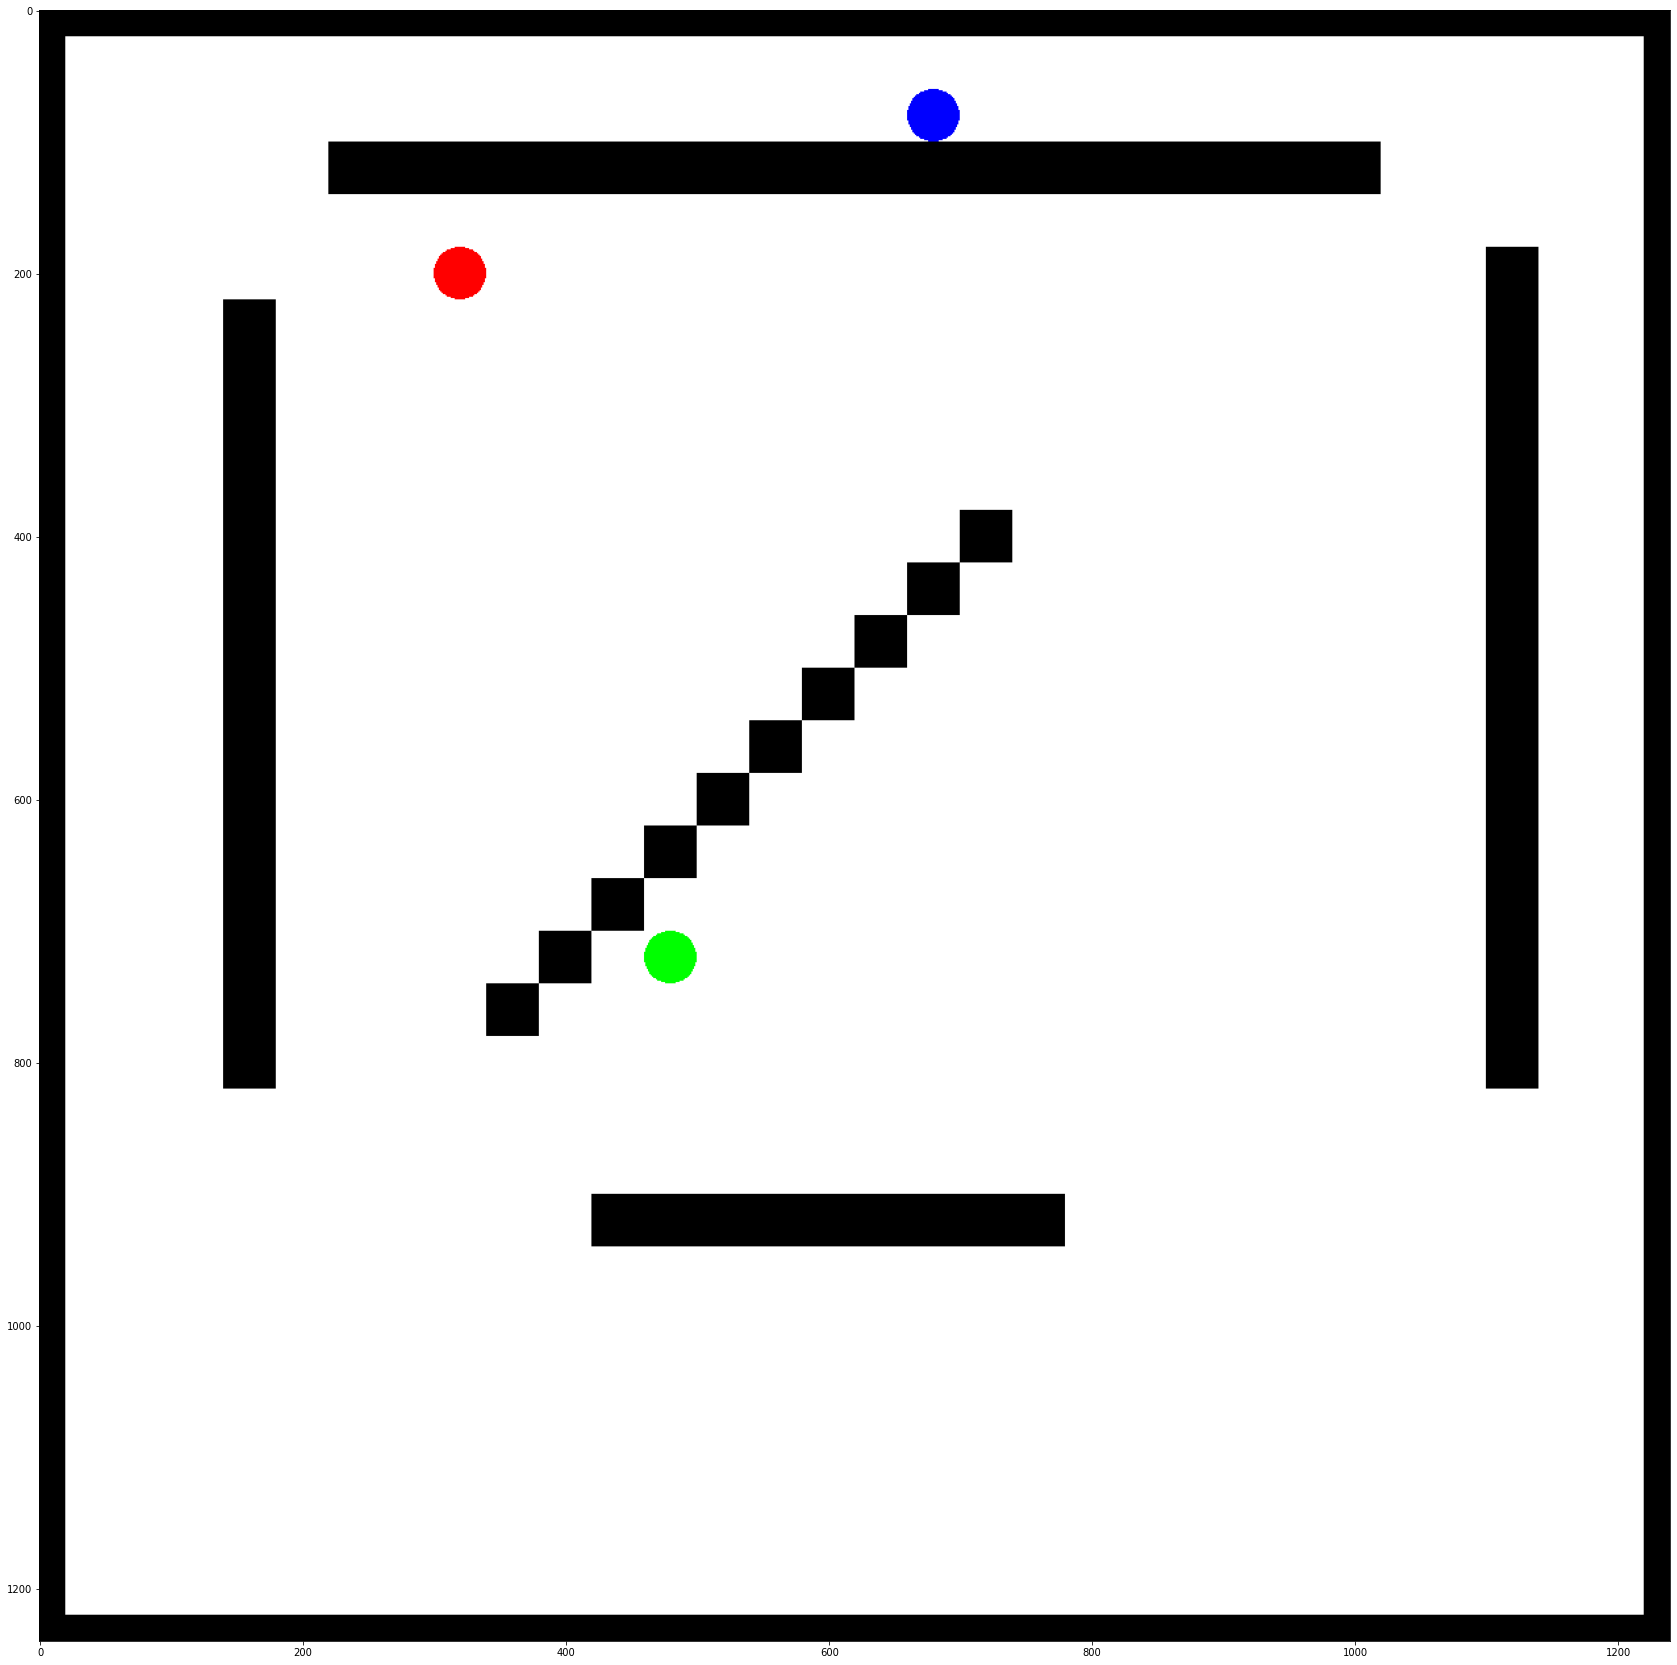

In [17]:

e_p = np.random.randint(0,4,(30,30,30,30))
p_p = np.random.randint(0,4,(30,30,30,30))
save_results(e_p,p_p)

In [31]:
e_p[[0,0]]

array([[1, 1, 2, 3, 1, 0, 3, 3, 2, 2, 3, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 0,
        2, 3, 3, 0, 1, 3, 3, 1],
       [1, 1, 2, 3, 1, 0, 3, 3, 2, 2, 3, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 0,
        2, 3, 3, 0, 1, 3, 3, 1]])

In [10]:
e_p

array([[[[0, 1, 3, ..., 2, 2, 1],
         [2, 3, 3, ..., 1, 0, 1],
         [2, 2, 1, ..., 1, 3, 0],
         ...,
         [1, 3, 3, ..., 3, 2, 0],
         [3, 2, 1, ..., 0, 0, 2],
         [0, 0, 1, ..., 3, 1, 0]],

        [[1, 2, 0, ..., 2, 3, 2],
         [3, 1, 3, ..., 2, 2, 0],
         [2, 0, 1, ..., 0, 3, 2],
         ...,
         [2, 3, 3, ..., 2, 1, 0],
         [0, 3, 2, ..., 0, 1, 3],
         [3, 0, 0, ..., 3, 2, 0]],

        [[3, 1, 3, ..., 1, 2, 2],
         [2, 0, 3, ..., 3, 3, 2],
         [2, 2, 2, ..., 2, 0, 1],
         ...,
         [3, 0, 0, ..., 1, 3, 3],
         [1, 2, 1, ..., 0, 3, 0],
         [3, 2, 1, ..., 3, 0, 1]],

        ...,

        [[3, 2, 1, ..., 3, 3, 3],
         [2, 0, 2, ..., 2, 2, 3],
         [2, 0, 2, ..., 2, 1, 2],
         ...,
         [2, 1, 0, ..., 0, 1, 2],
         [1, 3, 1, ..., 1, 2, 1],
         [2, 3, 3, ..., 1, 3, 3]],

        [[2, 3, 3, ..., 0, 2, 1],
         [0, 2, 0, ..., 0, 3, 0],
         [2, 1, 1, ..., 3, 1, 3],
    